### **Experiments**

In [2]:
import sys
sys.path.append('../')
sys.path.append('../nn_survival_analysis')
from nn_survival_analysis.general_utils import *
from nn_survival_analysis.model_utils import *
from nn_survival_analysis.losses import *
from nn_survival_analysis.models import *
from nn_survival_analysis.other_nn_models import *
from nn_survival_analysis.time_invariant_surv import *
from nn_survival_analysis.time_variant_surv import *
from nn_survival_analysis.traditional_models import *

# define sigmoid function - will be handy later
sigmoid = lambda z : 1 / (1 + np.exp(-z))

config_file_path = '../nn_survival_analysis/config.json'

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
data_folder_path = '../data/'

# Get configs
with open(config_file_path, "r") as file:
        configs = json.load(file)

# Read the pickled DataFrames
with open(data_folder_path+'x_train.pickle', 'rb') as file:
    x_train = pickle.load(file)
with open(data_folder_path+'x_test.pickle', 'rb') as file:
    x_test = pickle.load(file)
with open(data_folder_path+'x_val.pickle', 'rb') as file:
    x_val = pickle.load(file)

### **1. Supervised Learning**

#### 1.1 Trying with different cluster size

In [3]:
configs['time_invariant']['training']['clusters'] = 2

In [4]:
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train,
        test_data = x_test, 
        val_data = x_val
)

# fit
tis.fit(verbose = False)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)
print(tis_cindex , tis_ibs)

shapes : (1325, 1325, 1325, 1325)
0.6550568035284192 0.32004687416920047


#### 1.2 Adding PCA to reduce number of components

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

In [6]:
# strip of target cols
feed_to_pca = lambda x:x.iloc[: , :-2]

x_train_b4_pca = feed_to_pca(x_train)
x_test_b4_pca = feed_to_pca(x_test)
x_val_b4_pca = feed_to_pca(x_val)

In [7]:
x_train_pca_0 = pd.DataFrame(pca.fit_transform(x_train_b4_pca))
x_test_pca_0 = pd.DataFrame(pca.fit_transform(x_test_b4_pca))
x_val_pca_0 = pd.DataFrame(pca.fit_transform(x_val_b4_pca))

In [8]:
# Check variance captured
np.sum(pca.explained_variance_ratio_)

0.70729005

In [9]:
x_train_pca = pd.concat([x_train_pca_0 , x_train.iloc[: , -2:]] , axis = 1)
x_test_pca = pd.concat([x_test_pca_0 , x_test.iloc[: , -2:]] , axis = 1)
x_val_pca = pd.concat([x_val_pca_0 , x_val.iloc[: , -2:]] , axis = 1)

In [10]:
#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train_pca,
        test_data = x_test_pca, 
        val_data = x_val_pca
)

# fit
tis.fit(verbose = False)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)
print(tis_cindex , tis_ibs)

shapes : (1325, 1325, 1325, 1325)
0.5099094727915688 0.331656913752975


#### 1.3 PCA & Clustering

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

# strip of target cols
feed_to_pca = lambda x:x.iloc[: , :-2]

x_train_b4_pca = feed_to_pca(x_train)
x_test_b4_pca = feed_to_pca(x_test)
x_val_b4_pca = feed_to_pca(x_val)

x_train_pca_0 = pd.DataFrame(pca.fit_transform(x_train_b4_pca))
x_test_pca_0 = pd.DataFrame(pca.fit_transform(x_test_b4_pca))
x_val_pca_0 = pd.DataFrame(pca.fit_transform(x_val_b4_pca))

# Check variance captured
print(np.sum(pca.explained_variance_ratio_))

x_train_pca = pd.concat([x_train_pca_0 , x_train.iloc[: , -2:]] , axis = 1)
x_test_pca = pd.concat([x_test_pca_0 , x_test.iloc[: , -2:]] , axis = 1)
x_val_pca = pd.concat([x_val_pca_0 , x_val.iloc[: , -2:]] , axis = 1)

# Increase cluster size
configs['time_invariant']['training']['clusters'] = 2

#-----------------------------------------------------------------------------------------------
# instantiate - Time Invariant Survival
tis = Time_Invariant_Survival(
        configs = configs, 
        train_data = x_train_pca,
        test_data = x_test_pca, 
        val_data = x_val_pca
)

# fit
tis.fit(verbose = False)
mean_ , up_ , low_ , y_test_dur , y_test_event = tis.predict() # Visualize -> tis.visualize(mean_ , up_ , low_ , _from = 40 , _to = 50 )
tis_cindex , tis_ibs = tis.evaluation(mean_ , y_test_dur , y_test_event, plot = False)

print(tis_cindex , tis_ibs)

0.7072898
shapes : (1325, 1325, 1325, 1325)
0.503372368001189 0.33172682429705747


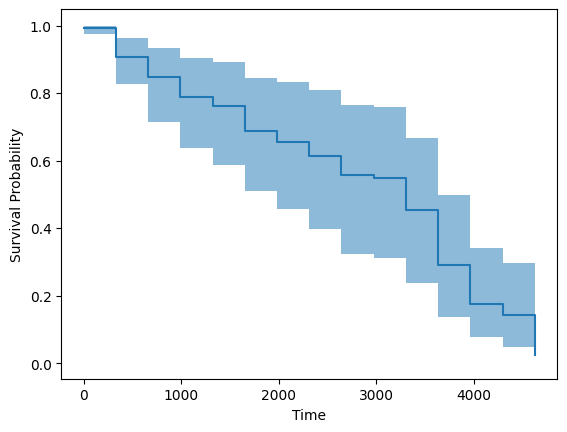

In [12]:
tis.visualize(mean_ , up_ , low_ , _from = 4 , _to = None )

### **2. Repeated Fits**

To get a dictionary like the following, run from the terminal
```
Set-ExecutionPolicy Unrestricted -Scope Process
{project_env}\Scripts\activate
cd experiments
python repeat_fits.py --iter 2 --verbose True
```

In [3]:
dict_fits = {
    'rsf': {
        'cindex': [0.6946371683059804, 0.6827858118086322, 0.6913167451493958, 0.6879359506626914, 0.6830969563561723, 0.6922594666889577, 0.6835195556670103, 0.6803848904492555, 0.6875412150426778, 0.6874529800217337], 
        'ibs': [0.1857709081068271, 0.18592070434098454, 0.1850240787985721, 0.1852421053841509, 0.18583617773995373, 0.18382146625545503, 0.18467297904833485, 0.18563686867877904, 0.18536194683068913, 0.18393412730514572]
    },
    'tvs': {
        'cindex': [0.7323220548846511, 0.7275402413183921, 0.7204840873885495, 0.7287939779197298, 0.7202509545494579, 0.7344202504364765, 0.7059106945804386, 0.7211627629867943, 0.7207534853359444, 0.725820239038871], 
        'ibs': [0.3671928439023087, 0.3703562133350622, 0.36997254733609825, 0.3598568243746608, 0.36831401716552836, 0.3733392051505076, 0.37779423633361253, 0.3599786194332382, 0.3778264504238799, 0.36814919902582277]
    }, 
    'tis': {
        'cindex': [0.677865713319842, 0.6672285485387213, 0.6696921844392681, 0.6754669099429937, 0.6724892447474079, 0.6766940969987172, 0.6748139538114578, 0.679116054848315, 0.6809915671410246, 0.6717344089357741], 
        'ibs': [0.33815294084174236, 0.34184265021098054, 0.34372409821554156, 0.3379439714822881, 0.33210178437974897, 0.333400164085733, 0.3451754778324478, 0.33637949727828825, 0.32884639337076726, 0.3416501467172673]
    }, 
    'cph': {
        'cindex': [0.6863477202856957, 0.6863477202856957, 0.6863477202856957, 0.6863477202856957, 0.6863477202856957, 0.6863477202856957, 0.6863477202856957, 0.6863477202856957, 0.6863477202856957, 0.6863477202856957], 
        'ibs': [0.15890010506008065, 0.15890010506008065, 0.15890010506008065, 0.15890010506008065, 0.15890010506008065, 0.15890010506008065, 0.15890010506008065, 0.15890010506008065, 0.15890010506008065, 0.15890010506008065]
    }, 
    'aft': {
        'cindex': [0.6822053182497887, 0.6822053182497887, 0.6822053182497887, 0.6822053182497887, 0.6822053182497887, 0.6822053182497887, 0.6822053182497887, 0.6822053182497887, 0.6822053182497887, 0.6822053182497887], 
        'ibs': [0.16582593737828685, 0.16582593737828685, 0.16582593737828685, 0.16582593737828685, 0.16582593737828685, 0.16582593737828685, 0.16582593737828685, 0.16582593737828685, 0.16582593737828685, 0.16582593737828685]
    },
    'pyc': {
        'cindex': [0.5729424986300352, 0.5829502075844967, 0.5792582685502522, 0.5886251126157505, 0.5676669731672658, 0.5872087083321723, 0.5720833681629469, 0.568841892130365, 0.5971653338534556, 0.5923077637530534], 
        'ibs': [0.1633795364977959, 0.16301942379895568, 0.1653579581833401, 0.16576243721548545, 0.16490769348917886, 0.1629516406966432, 0.1615301255704485, 0.16247955610357814, 0.16331700252651088, 0.16179109715912396]
    }, 
    'dsm': {
        'cindex': [0.6445707598428487, 0.6317116665273482, 0.6222844511317303, 0.6337085643697697, 0.6331605784502216, 0.6335274503794106, 0.6286698802790084, 0.6624731811975815, 0.6475893263488348, 0.6358262048724307], 
        'ibs': [0.24573682961914037, 0.25109080488723473, 0.2561601299780466, 0.2544078144320814, 0.25202220679006226, 0.2536470841518057, 0.2526303218152519, 0.23944953897682353, 0.2478469091076468, 0.25274218513084695]
    }
}

In [5]:
# dict_fits = {
#     'tvs': {
#         'cindex': [0.7224018246208733, 0.7261133169075605, 0.7221847324011446, 0.72514032527215, 0.7178533502822199, 0.7117956926811151, 0.7146205071065007, 0.7262336330775307, 0.7138567609840817, 0.7136841334358637], 
#         'ibs': [0.36797406596513416, 0.3709111966353304, 0.36725453870356556, 0.3764632001412606, 0.3721288492190593, 0.3745771862117764, 0.3756849018192498, 0.374173373275104, 0.37839087826975115, 0.36356568826216346]
#         }, 
#     'tis': {
#         'cindex': [0.7017279644895371, 0.692230221194375, 0.697955910328621, 0.7010751986273266, 0.6997230407698907, 0.7027257637360588, 0.705201611399157, 0.7001193629005185, 0.6979512477153195, 0.6960489014883061], 
#         'ibs': [0.4223844343072177, 0.4257995374134107, 0.43033377346061574, 0.4246115213138635, 0.42581609832882444, 0.4213766763966916, 0.4266165932120578, 0.4146521131242105, 0.41892248393447906, 0.42437463812629134]
#         }, 
#     'cph': {
#         'cindex': [0.7055785365397649, 0.7055785365397649, 0.7055785365397649, 0.7055785365397649, 0.7055785365397649, 0.7055785365397649, 0.7055785365397649, 0.7055785365397649, 0.7055785365397649, 0.7055785365397649], 
#         'ibs': [0.17410576124377045, 0.17410576124377045, 0.17410576124377045, 0.17410576124377045, 0.17410576124377045, 0.17410576124377045, 0.17410576124377045, 0.17410576124377045, 0.17410576124377045, 0.17410576124377045]
#         }, 
#     'aft': {
#         'cindex': [0.7074995910163827, 0.7074995910163827, 0.7074995910163827, 0.7074995910163827, 0.7074995910163827, 0.7074995910163827, 0.7074995910163827, 0.7074995910163827, 0.7074995910163827, 0.7074995910163827], 
#         'ibs': [0.17571855087291768, 0.17571855087291768, 0.17571855087291768, 0.17571855087291768, 0.17571855087291768, 0.17571855087291768, 0.17571855087291768, 0.17571855087291768, 0.17571855087291768, 0.17571855087291768]
#         },
#     'pyc': {
#         'cindex': [0.6398653859636823, 0.6240949776811797, 0.6248568557339503, 0.603701885998738, 0.5846268900885742, 0.6111103320946972, 0.5898712285867863, 0.5766575521746243, 0.6050854191497815, 0.6263946341349412], 
#         'ibs': [0.185703217140601, 0.18419431362009342, 0.1885125115023738, 0.1864750508313879, 0.1856505259781314, 0.1846424030364299, 0.18410019939550284, 0.18216953733901187, 0.184741837771625, 0.18328240347492933]
#         }, 
#     'dsm': {
#         'cindex': [0.6625207413120194, 0.6674846339012362, 0.6433662857276403, 0.6659421814017621, 0.674350884573138, 0.664418425296221, 0.6518404262777817, 0.6631938114936081, 0.6632732711678235, 0.6544111804435719], 
#         'ibs': [0.2741155868837711, 0.27495346533550025, 0.28558186057445517, 0.2733886385629673, 0.2710429359459442, 0.27603908554515233, 0.27962866451242396, 0.27359101741676467, 0.27266032357716324, 0.2816053583253264]
#         },
#     'rsf': {
#         'cindex': [0.704442730608334, 0.7153287059758349, 0.7098646848489097, 0.7097151136974456, 0.7187501460655776, 0.7098600107504265, 0.7146369394003131, 0.712454135408633, 0.711481922924116, 0.7072939306831195], 
#         'ibs': [0.20453408416023894, 0.20231085663928475, 0.20269646114774262, 0.20354918027769564, 0.2031119423550705, 0.2040444977586439, 0.20402816315659664, 0.20207826736985712, 0.20351577867594073, 0.20295164667147228]
#         }
#     }

In [4]:
print(np.quantile(dict_fits['tvs']['cindex'] , q = [0.05 , 0.5 , 0.95]) , np.quantile(dict_fits['tvs']['ibs'] , q = [0.05 , 0.5 , 0.95]))
print(np.quantile(dict_fits['tis']['cindex'] , q = [0.05 , 0.5 , 0.95]) , np.quantile(dict_fits['tis']['ibs'] , q = [0.05 , 0.5 , 0.95]))
print(np.quantile(dict_fits['pyc']['cindex'] , q = [0.05 , 0.5 , 0.95]) , np.quantile(dict_fits['pyc']['ibs'] , q = [0.05 , 0.5 , 0.95]))
print(np.quantile(dict_fits['dsm']['cindex'] , q = [0.05 , 0.5 , 0.95]) , np.quantile(dict_fits['dsm']['ibs'] , q = [0.05 , 0.5 , 0.95]))
print(np.quantile(dict_fits['rsf']['cindex'] , q = [0.05 , 0.5 , 0.95]) , np.quantile(dict_fits['rsf']['ibs'] , q = [0.05 , 0.5 , 0.95]))

[0.71236381 0.7234915  0.73347606] [0.35991163 0.36914328 0.37781195]
[0.66833718 0.67514043 0.68014759] [0.33031132 0.33804846 0.34452236]
[0.56819569 0.58110424 0.59497943] [0.16164756 0.16316821 0.16558042]
[0.62515789 0.63361801 0.65577545] [0.24227882 0.25232626 0.25537159]
[0.68146531 0.6874971  0.6935672 ] [0.18387216 0.18530203 0.18588267]


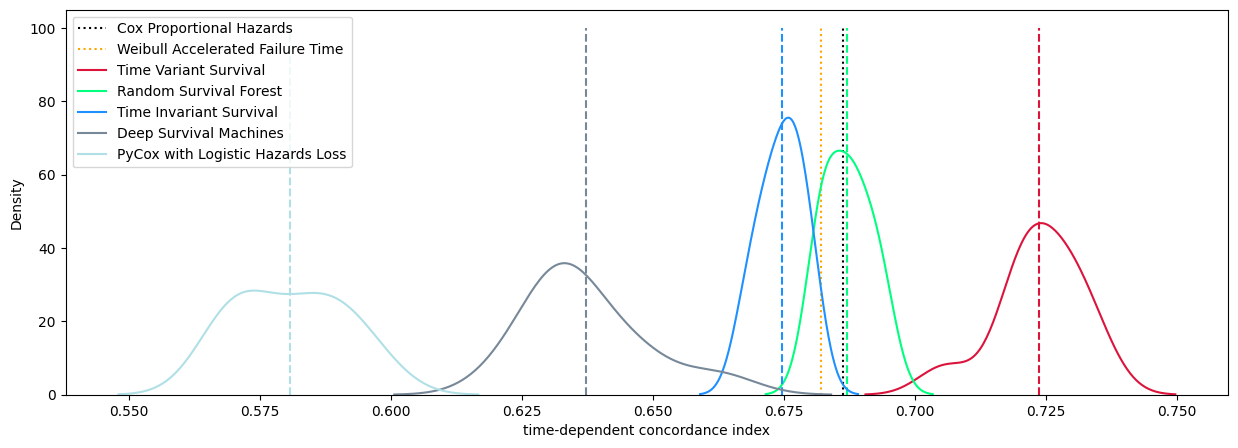

In [5]:
import seaborn as sns

criteria = 'cindex'

fig , ax = plt.subplots(figsize = (15 , 5))

plt.vlines(np.mean(np.array(dict_fits['cph'][criteria])) , ymin = 0 , ymax = 100 , color = 'black' , ls=':' ,
           label = 'Cox Proportional Hazards')
plt.vlines(np.mean(np.array(dict_fits['aft'][criteria])) , ymin = 0 , ymax = 100 , color = 'orange' , ls=':' ,
           label = 'Weibull Accelerated Failure Time')

sns.kdeplot(np.array(dict_fits['tvs'][criteria]) , label = 'Time Variant Survival' , color = 'crimson');
plt.vlines(np.mean(np.array(dict_fits['tvs'][criteria])) , ymin = 0 , ymax = 100 , ls = '--' , color = 'crimson')

sns.kdeplot(np.array(dict_fits['rsf'][criteria]) , label = 'Random Survival Forest' , color = 'springgreen');
plt.vlines(np.mean(np.array(dict_fits['rsf'][criteria])) , ymin = 0 , ymax = 100 , ls = '--' , color = 'springgreen')

sns.kdeplot(np.array(dict_fits['tis'][criteria]) , label = 'Time Invariant Survival' , color = 'dodgerblue');
plt.vlines(np.mean(np.array(dict_fits['tis'][criteria])) , ymin = 0 , ymax = 100 , ls = '--' , color = 'dodgerblue')

sns.kdeplot(np.array(dict_fits['dsm'][criteria]) , label = 'Deep Survival Machines' , color = 'lightslategray');
plt.vlines(np.mean(np.array(dict_fits['dsm'][criteria])) , ymin = 0 , ymax = 100 , ls = '--' , color = 'lightslategray')

sns.kdeplot(np.array(dict_fits['pyc'][criteria]) , label = 'PyCox with Logistic Hazards Loss', color = 'powderblue');
plt.vlines(np.mean(np.array(dict_fits['pyc'][criteria])) , ymin = 0 , ymax = 100 , ls = '--' , color = 'powderblue')
plt.legend(loc='upper left');
plt.xlabel('time-dependent concordance index')

# Save the plot as an SVG file
plt.savefig('cindex_score_dist_plot.pdf', format='pdf')

plt.show()

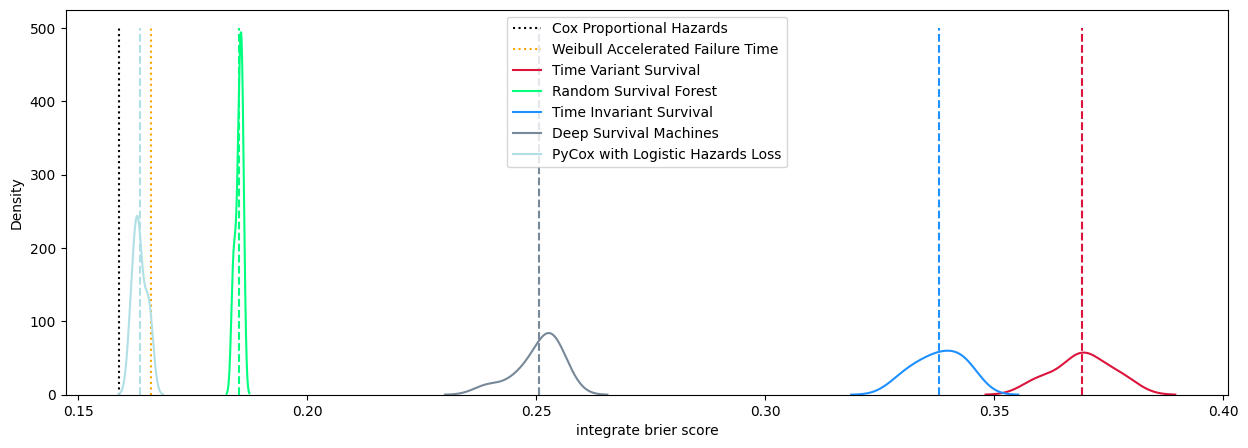

In [6]:
import seaborn as sns

criteria = 'ibs'
ymax = 500

fig , ax = plt.subplots(figsize = (15 , 5))

plt.vlines(np.mean(np.array(dict_fits['cph'][criteria])) , ymin = 0 , ymax = ymax , color = 'black' , ls=':' ,
           label = 'Cox Proportional Hazards')
plt.vlines(np.mean(np.array(dict_fits['aft'][criteria])) , ymin = 0 , ymax = ymax , color = 'orange' , ls=':' ,
           label = 'Weibull Accelerated Failure Time')

sns.kdeplot(np.array(dict_fits['tvs'][criteria]) , label = 'Time Variant Survival' , color = 'crimson');
plt.vlines(np.mean(np.array(dict_fits['tvs'][criteria])) , ymin = 0 , ymax = ymax , ls = '--' , color = 'crimson')

sns.kdeplot(np.array(dict_fits['rsf'][criteria]) , label = 'Random Survival Forest' , color = 'springgreen');
plt.vlines(np.mean(np.array(dict_fits['rsf'][criteria])) , ymin = 0 , ymax = ymax , ls = '--' , color = 'springgreen')

sns.kdeplot(np.array(dict_fits['tis'][criteria]) , label = 'Time Invariant Survival' , color = 'dodgerblue');
plt.vlines(np.mean(np.array(dict_fits['tis'][criteria])) , ymin = 0 , ymax = ymax , ls = '--' , color = 'dodgerblue')

sns.kdeplot(np.array(dict_fits['dsm'][criteria]) , label = 'Deep Survival Machines' , color = 'lightslategray');
plt.vlines(np.mean(np.array(dict_fits['dsm'][criteria])) , ymin = 0 , ymax = ymax , ls = '--' , color = 'lightslategray')

sns.kdeplot(np.array(dict_fits['pyc'][criteria]) , label = 'PyCox with Logistic Hazards Loss', color = 'powderblue');
plt.vlines(np.mean(np.array(dict_fits['pyc'][criteria])) , ymin = 0 , ymax = ymax , ls = '--' , color = 'powderblue')
plt.legend(loc='upper center');
plt.xlabel('integrate brier score')

# Save the plot as an SVG file
plt.savefig('ibs_dist_plot.pdf', format='pdf')

plt.show()